In [1]:
import json
import functools
from glob import glob
import os
import itertools
from importlib import reload

os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import persim
import utils
from sklearn import decomposition, preprocessing

In [3]:
exclude_nuclei = True
normtype = 'both'
level = 'sub'
n_components = 2
fs = 12
dpi = 96
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
sample = 'D2'

seed = 42
ndims = 3
perms = [np.nonzero(p)[0] for p in itertools.product(range(2), repeat=ndims)][1:]

ksrc = '..' + os.sep + 'kde' + os.sep + sample + os.sep
tsrc = '..' + os.sep + 'translocs' + os.sep + sample + os.sep
dst = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = '..' + os.sep + level + 'level' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 'ndimage_cellID')
Cells = utils.get_range_cell_values(dst + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)
    
if exclude_nuclei:
    transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene').rename(columns=int)
    transcriptomes = np.asarray(transcell.index, dtype=str)
    Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
else:
    transcell = pd.read_csv(ksrc + sample + '_transcells_metadata_w_nucleus.csv', index_col='gene').rename(columns=int)
    transcriptomes = np.asarray(transcell.index, dtype=str)
    Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection_w_nucleus.csv', transcriptomes, startval=0)

In [35]:
transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ 5 ]]), Cells]
transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ :2 ]]), Cells]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')
genes = '_-_'.join(sorted([ g.split('_')[-1] for g in ratios.index ]))
print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	0.29%


,169,188,199,209,224,227,233,235,236,243,...,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_17G195900,1017,2397,727,307,1012,902,834,1286,1381,320,...,809,1299,181,210,1106,366,681,764,574,771
GLYMA_05G092200,456,1687,637,503,465,481,627,971,684,324,...,654,818,199,407,1065,417,428,711,345,477


In [36]:
print((ratios > 0).sum(axis = 1))
PP = 6
stepsize = 3
bw = 25

foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
jsonfiles = dict()

for t in transfocus.index:
    jsonfiles[t] = [ foo.format(gsrc, t, t, level, PP, stepsize, bw, Cells[i]) for i in range(ratios.shape[1]) ]

orig_diags = utils.get_diagrams(jsonfiles, ndims, remove_inf=True)
nzcumsum = np.hstack(([0], np.cumsum(list(map(len, iter(orig_diags.values()))))))
bsummary = pd.DataFrame(index=range(nzcumsum[-1]), columns=['gene','ndimage_ID'] )
print(list(map(len, iter(orig_diags.values()))))

gene
GLYMA_17G195900    918
GLYMA_05G092200    918
dtype: int64
[918, 918]


In [24]:
reload(utils)
SCALE = 32
diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
print(list(map(len, iter(diags.values()))))

maxxlife = max( list(map(np.max, iter(maxlife.values()))) )
maxxlife

Initial number of life-birth pairs	: 4130

No. of diagrams s.t. H_k had the most persistent component
H_0:	0 [ 0.0% ]
H_1:	22 [ 2.4% ]
H_2:	419 [ 45.6% ]

Will focus just on dimension k = 2

[441]


10.629216045638412

In [9]:
i = 0
maxbirth = 0
lt_diags = dict()
for gene in diags:
    lt_diags[gene] = dict()
    for cidx in diags[gene]:
        bsummary.iloc[i] = [gene, cidx]
        i += 1
        lt_diags[gene][cidx] = [ None for _ in range(len(diags[gene][cidx])) ]
        for k in range(len(diags[gene][cidx])): 
            foo = rescale*diags[gene][cidx][k].copy()
            lt_diags[gene][cidx][k] = np.column_stack( (foo[:,0], foo[:,1] - foo[:,0]) )
            if (len(lt_diags[gene][cidx][k]) > 0) and (lt_diags[gene][cidx][k][:,0].max() > maxbirth):
                maxbirth = lt_diags[gene][cidx][k][:,0].max()

bsummary = bsummary.astype({'ndimage_ID':int})
print(list(map(len, iter(lt_diags.values()))), maxbirth)

[441] 24.217898739666328


# Persistence Images

In [14]:
sigma = 1
persw = 1
pixsz = 1
iqr_factor = 1.5

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxxlife + sigma))])),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
print(extent)
tdst = dst + '{}_bw{}_{}level'.format(genes, bw, level) + os.sep
bname = tdst + 'PI_scale{}_'.format(SCALE)
Bname = 'PIs: KDE bandwidth {}. {}level persistence. Scale {}'.format(bw, level.title(), SCALE)
print(bname, Bname, sep='\n')

if not os.path.isdir(tdst):
    os.mkdir(tdst)

[ 0 26  0 17]
../infected_focus_summer24/D2/05G203100_bw25_sublevel/PI_scale32_
PIs: KDE bandwidth 25. Sublevel persistence. Scale 32
../infected_focus_summer24/D2/05G203100_bw25_sublevel/


In [15]:
img = dict()
for gene in lt_diags:
    img[gene] = dict()
    for cidx in lt_diags[gene]:
        img[gene][cidx] = np.asarray( [ pimgr.transform( lt_diags[gene][cidx][k] , skew=False) for k in range(len(lt_diags[gene][cidx])) ])
        img[gene][cidx][ img[gene][cidx] < 0 ] = 0

pi = np.zeros((ndims, sum(list(map(len, iter(lt_diags.values())))), extent[1]*extent[3]))
for k in range(len(pi)):
    i = 0
    for gene in img:
        for cidx in img[gene]:
            pi[k,i] = img[gene][cidx][k].ravel()
            i += 1
print(pi.size, pi.shape)

584766 (3, 441, 442)


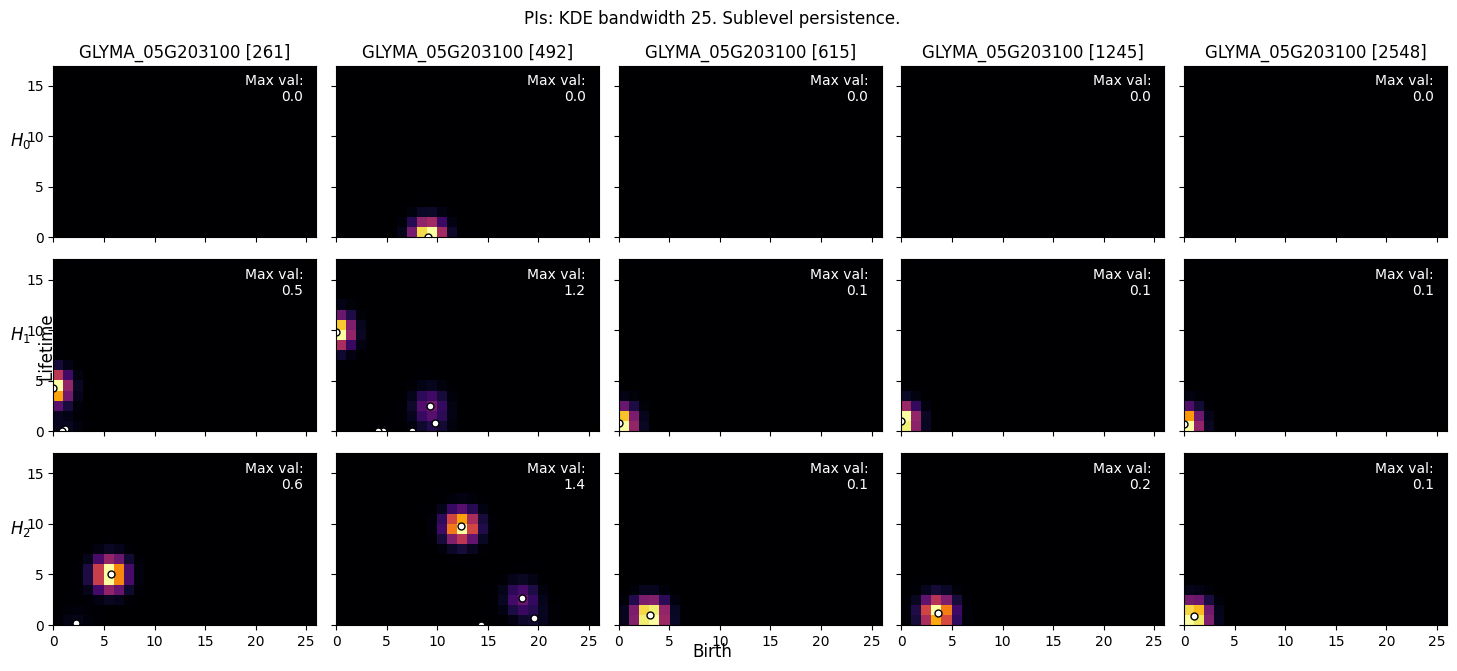

In [13]:
idx = Cells[ [11, 90, 155, 456, 914] ]
gs = [ ratios.index[-1] for _ in range(len(idx)) ]

fig, ax = plt.subplots(ndims, len(idx), figsize=(3*len(idx), 7), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(ndims):
    for i in range(len(idx)):
        ax[k,i].imshow(img[gs[i]][idx[i]][k].T, cmap='inferno', vmin=0, origin='lower', extent=extent)
        ax[k,i].text((extent[1] - extent[0])*.95, (extent[3] - extent[2])*.95, 
                    'Max val:\n{:.1f}'.format(np.max(img[gs[i]][idx[i]][k])), color='w', ha='right', va='top')
        foo = lt_diags[gs[i]][idx[i]][k]
        ax[k,i].scatter(foo[:,0], foo[:,1], c='w', marker='o', s=25, edgecolor='k', linewidth=1)
    ax[k,0].set_ylabel('$H_{}$'.format(k), fontsize=fs, rotation=0)

for i in range(len(idx)):
    ax[0,i].set_title('{} [{}]'.format(gs[i], idx[i]), fontsize=fs)

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();

In [16]:
alpha = 0.25
maxpis = np.max(pi, axis=2)
maxxpis = maxpis.max()
boxes = [ [ maxpis[k, nzcumsum[i]:nzcumsum[i+1]] for i in range(len(nzcumsum)-1) ] for k in range(len(maxpis)) ]
qq = np.asarray([ [ np.quantile(boxes[k][i], [alpha, 1-alpha]) for i in range(len(boxes[k])) ] for k in range(len(boxes)) ])
thr = np.max(qq[:,:,1] + iqr_factor*(qq[:,:,1] - qq[:,:,0]), axis=1)

avg = np.zeros( (ndims, len(nzcumsum) - 1, pimgr.resolution[1], pimgr.resolution[0]))
for k in range(len(avg)):
    for i in range(avg.shape[1]):
        avg[k,i] = np.mean(pi[ k, nzcumsum[i]:nzcumsum[i+1] ], axis=0).reshape(avg.shape[3], avg.shape[2]).T
avgmax = avg.max()

../infected_focus_summer24/D2/05G203100_bw25_sublevel/PI_scale32_average


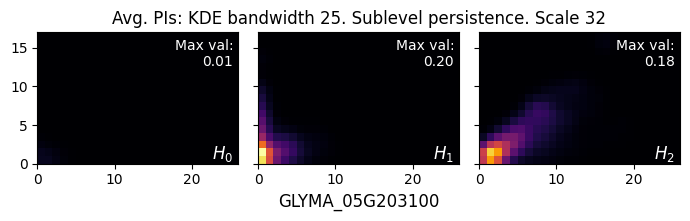

In [17]:
fig, ax = plt.subplots(len(ratios), len(avg), figsize=(7, 2*len(ratios)), sharex=True, sharey=True)
ax = np.atleast_2d(ax)

for i in range(len(ratios)):
    for k in range(len(avg)):
        ax[i,k].text((extent[1] - extent[0])*.975, 0, '$H_{}$'.format(k), fontsize=fs, color='w', ha='right', va='bottom')
        ax[i,k].imshow(avg[k,i], cmap='inferno', origin='lower', vmin=0, vmax=avgmax, extent=extent)
        ax[i,k].text((extent[1] - extent[0])*.975, (extent[3] - extent[2])*.95, 
                     'Max val:\n{:.2f}'.format(np.max(avg[k,i])), color='w', ha='right', va='top')
    ax[i,1].set_xlabel(ratios.index[i], fontsize=fs)

ax[0,1].set_title('Avg. ' + Bname, fontsize=fs)
fig.tight_layout()
filename = bname + 'average.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

# Reduce dimension

../infected_focus_summer24/D2/05G203100_bw25_sublevel/PI_scale32_max_vals


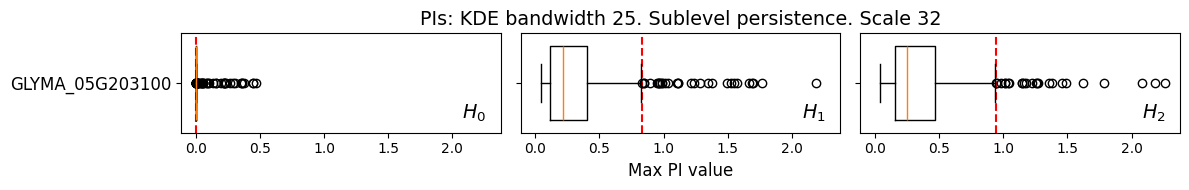

In [25]:
fig, ax = plt.subplots(1, len(thr), figsize=(12, max([1.25*len(ratios), 2])), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); 
for k in range(len(ax)):
    ax[k].axvline(thr[k], c='r', ls='--', zorder=1)
    ax[k].boxplot(boxes[k], vert=False, zorder=2, widths=0.75)
    ax[k].text(maxxpis, 0.8, '$H_{}$'.format(k), fontsize=1.15*fs, ha='right', va='top')

ax[0].set_yticks(range(1, len(lt_diags)+1), iter(lt_diags.keys()), fontsize=fs)

ax[1].set_title(Bname, fontsize=1.15*fs)
ax[1].set_xlabel('Max PI value', fontsize=fs)
filename = tdst + bname + 'max_PI_val_boxplot'
fig.tight_layout()
filename = bname + 'max_vals.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

In [26]:
perm = perms[2]
print(perm)
pname = 'H' + '+'.join(perm.astype(str))
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in perm]) + '$]'
full_pi = np.hstack(pi[perm])
print(full_pi.shape)
maxmask = np.ones(len(full_pi), dtype=bool)
maxmask[functools.reduce(np.union1d, [np.nonzero(maxpis[k] > thr[k])[0] for k in perm])] = False
print(full_pi[maxmask].shape)

scaler = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True)
data = scaler.fit_transform(full_pi[maxmask].copy())
fulldata = scaler.transform(full_pi)
print(data.shape, fulldata.shape)
print(np.quantile(fulldata[fulldata > 0], 0.99))

[1 2]
(441, 884)
(408, 884)
(408, 884) (441, 884)
0.9477957176514186


# PCA

In [45]:
PCA = decomposition.PCA(n_components=min([6, data.shape[1]//20]), random_state=seed)
print('Considering the first', PCA.n_components,'PCs')
PCA.fit(data)
print(np.sign(np.sum(np.sign(PCA.components_), axis=1)))

pca = PCA.transform(fulldata).astype('float32')
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

Considering the first 6 PCs
[-1.  1.  1.  1.  1. -1.]
[31.15867731 22.17252186 11.83481338  7.16987676  5.75785157  4.34741377]
Total explained var:	 82.44115464920475 53.33119917033109


../infected_focus_summer24/D2/05G203100_bw25_sublevel/PI_scale32_loadings.png


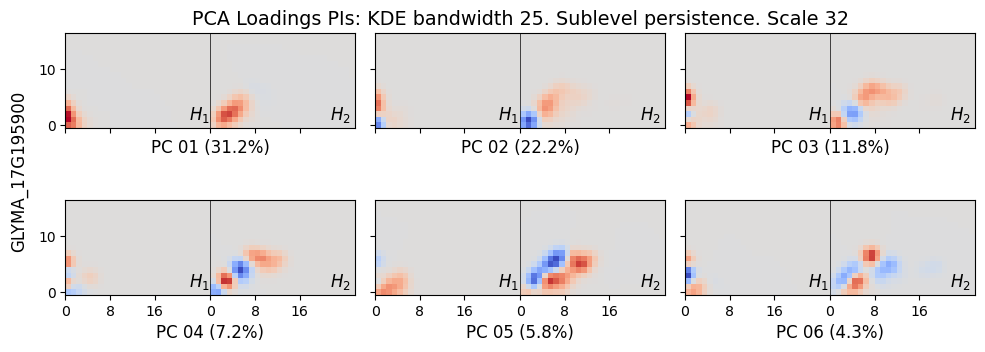

In [46]:
pcacol = 3
pcarow = np.where(pca.shape[1] % pcacol == 0, pca.shape[1]//pcacol, pca.shape[1]//pcacol + 1) + 0

xlabs = np.tile(np.arange(0, extent[1]-2, extent[1]//3), len(perm))
xticks = np.hstack([ np.arange(0, extent[1]-2, xlabs[1]-xlabs[0]) + i*extent[1] for i in range(len(perm)) ]) - 0.5

fig, ax = plt.subplots(pcarow, pcacol, figsize=(10, 2.0*pcarow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(loadings.shape[1]):
    ll = loadings[:,i].reshape( len(perm)*extent[1], extent[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower')
    ax[i].set_xlabel('PC {:02d} ({:.1f}%)'.format(i+1, explained_ratio[i]), fontsize=fs)
    for j in range(1, len(perm)):
        ax[i].axvline(j*extent[1] - 0.5, c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs, fontsize=0.85*fs)
    for k in perm:
        ax[i].text(.975*(k*extent[1]), 0, '$H_{}$'.format(k), c='k', va='bottom', ha='right', fontsize=fs)

for i in range(loadings.shape[1], len(ax)):
    fig.delaxes(ax[i])
ax[pcacol//2].set_title('PCA Loadings ' + Bname, fontsize=1.15*fs)
fig.supylabel(ratios.index[0], fontsize=fs)
fig.tight_layout();
filename = bname + 'loadings.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

In [55]:
pcacols = ['PC {:02d} ({:.2f})'.format(i+1,explained_ratio[i]) for i in range(pca.shape[1])]
summary = bsummary.join(pd.DataFrame(pca, columns=pcacols))
minspos = 1.2*summary[pcacols[:2]].min().values
filename = bname + 'pca.csv'
print(filename)
#summary.to_csv(filename, index=False)
summary

../infected_focus_summer24/D2/G1_bw25_sublevel/12G027400_PI_scale32_pca.csv


,gene,ndimage_ID,PC 01 (35.01),PC 02 (20.92),PC 03 (8.29),PC 04 (6.78),PC 05 (4.52),PC 06 (3.36)
0,GLYMA_12G027400,169,1.239485,0.098286,0.136527,-0.937825,0.572321,-0.215396
1,GLYMA_12G027400,188,7.313181,-0.180233,1.664886,-0.540480,0.558922,0.205171
2,GLYMA_12G027400,199,1.567021,-1.367694,0.514130,0.201313,0.091040,0.345943
3,GLYMA_12G027400,209,-0.725873,2.196082,-0.450300,0.023052,-0.237336,-0.360020
4,GLYMA_12G027400,224,-0.112021,0.162851,0.460422,-0.362157,0.245908,-0.000202
...,...,...,...,...,...,...,...,...
912,GLYMA_12G027400,2536,-0.366937,-0.291424,0.168177,-0.132859,-0.676959,-0.108356
913,GLYMA_12G027400,2548,-2.166395,0.318304,0.649531,-0.679702,0.105225,-0.034125
914,GLYMA_12G027400,2552,0.287545,1.086192,-0.460860,-0.466159,-0.102481,0.330645
915,GLYMA_12G027400,2573,0.406797,-1.904113,0.314873,0.796862,-0.669937,0.432514


NameError: name 'summary' is not defined

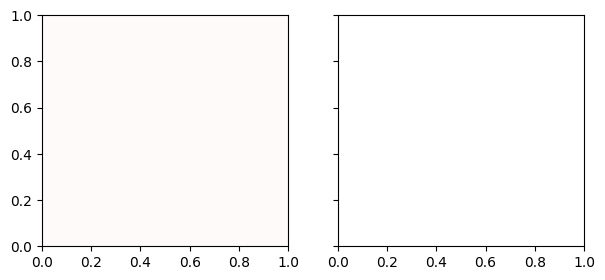

In [44]:
nrows = 1
ncols = len(ratios)//nrows
fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols,2*nrows+1), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    gene = ratios.index[i]
    ax[i].set_facecolor('snow')
    ax[i].scatter(*summary.loc[ summary['gene'] != gene, pcacols[:2] ].T.values, c='lightgray', marker='.', s=1, alpha=1, zorder=1)
    ax[i].scatter(*summary.loc[ summary['gene'] == gene, pcacols[:2] ].T.values, c=color[i], marker=marker[i], alpha=0.75, zorder=2,
                  edgecolor='k', linewidth=0.5)
    ax[i].set_title(gene)
    ax[i].text(*minspos, Pname, ha='left', va='bottom', fontsize=0.85*fs)
    ax[i].margins(0.1)

for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
    fig.delaxes(ax[-i])

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
fig.supylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs)

fig.tight_layout();
filename = bname + 'pca_' + pname
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [13]:
def plot_embedding(embedding, alpha=0.05, title=None, nrows=2, ncols=4):
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nzcumsum) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', s=1, alpha=1, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=color[i], marker=marker[i], alpha=0.75, zorder=2,
                      edgecolor='k', linewidth=0.5)
        ax[i].set_title(transcriptomes[Genes[i]])
        ax[i].set_xlim(mn[0],mx[0]);ax[0].set_ylim(mn[1],mx[1])
        #ax[i].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if title is not None:
        fig.supxlabel(title + ' 01')
        fig.supylabel(title + ' 02')
    
    return fig, ax

# KPCA

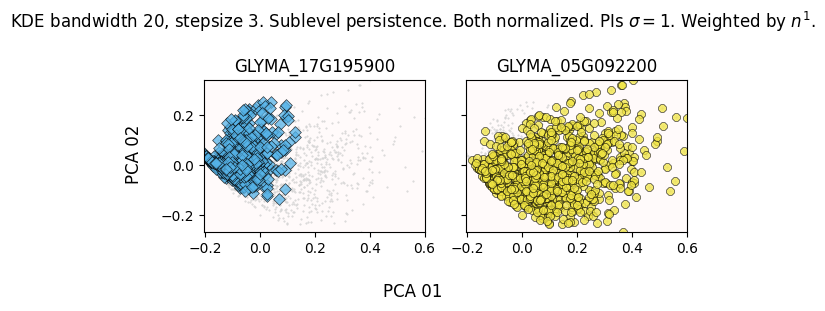

In [20]:
params = {'kernel':'rbf', 'gamma':0.01}
#params = {'kernel':'poly', 'gamma':0.1, 'degree':3}
#params = {'kernel':'sigmoid', 'gamma':0.1}

KPCA = decomposition.KernelPCA(n_components=2, **params)
KPCA.fit(data)
kpca = KPCA.transform(fulldata).astype('float32')

fig, ax = plot_embedding(kpca, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();

# Locally Linear Embeddings

In [21]:
import umap
from sklearn import decomposition, preprocessing, manifold

In [22]:
method = 'LLE'
n_neighbors = 24  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2, "eigen_solver": "auto","random_state": seed}
LLE = manifold.LocallyLinearEmbedding(method="standard", **params)
LLE.fit(data)
lle = LLE.transform(fulldata).astype('float32')
params = LLE.get_params()

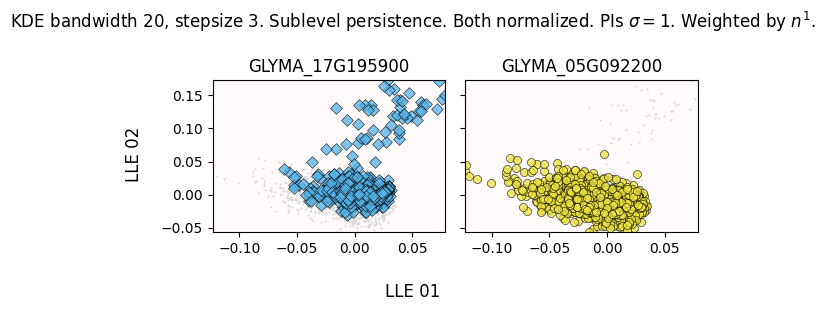

In [23]:
summary = pd.DataFrame(lle, columns=['{}{:02d}'.format(method, i+1) for i in range(lle.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(lle.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}_{}.csv'.format(method.lower(), LLE.method, params['n_neighbors']))

fig, ax = plot_embedding(lle, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}'.format(method.lower(), LLE.method, params['n_neighbors']) + '_' + pname
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Isomap

In [24]:
method = 'ISO'
n_neighbors = 16  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2,"eigen_solver": "auto"}
ISO = manifold.Isomap(**params)
ISO.fit(data)
iso = ISO.transform(fulldata).astype('float32')
params = ISO.get_params()
ISO.reconstruction_error()

0.5632392146939129

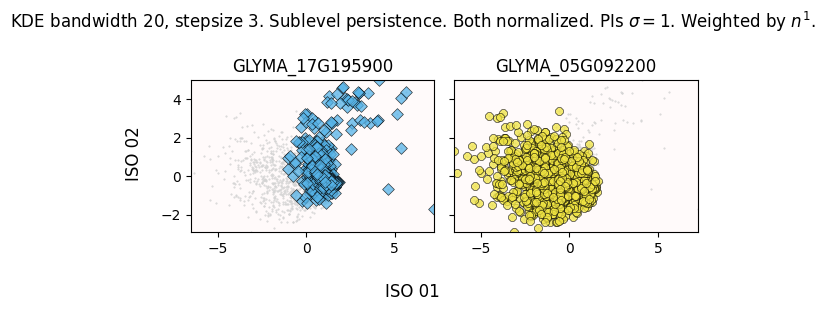

In [25]:
summary = pd.DataFrame(iso, columns=['{}{:02d}'.format(method, i+1) for i in range(iso.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(iso.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}.csv'.format(method.lower(), params['n_neighbors']))

fig, ax = plot_embedding(iso, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['n_neighbors'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# tSNE

In [26]:
method = 'tSNE'
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=25,
    init="random",
    n_iter=250,
    random_state=seed,
)
tsne = t_sne.fit_transform(fulldata).astype('float32')
params = t_sne.get_params()

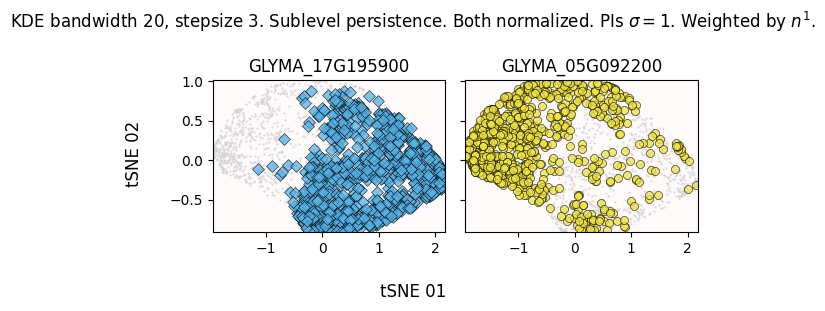

In [27]:
summary = pd.DataFrame(tsne, columns=['{}{:02d}'.format(method, i+1) for i in range(tsne.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(tsne.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}.csv'.format(method.lower(), params['perplexity']))

fig, ax = plot_embedding(tsne, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['perplexity'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# UMAP

In [28]:
method = 'UMAP'
ufit = umap.UMAP(n_neighbors=10, min_dist=0.25, n_components=2, metric='euclidean', random_state=seed, n_jobs=1)
u_umap = ufit.fit_transform(fulldata);
params = ufit.get_params();

/home/eah4d/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


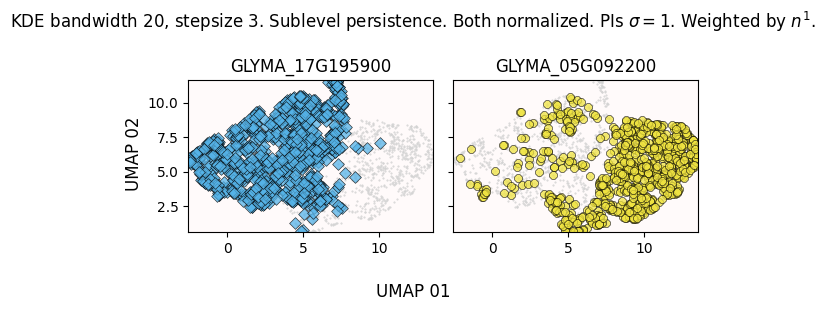

In [30]:
summary = pd.DataFrame(u_umap, columns=['{}{:02d}'.format(method, i+1) for i in range(u_umap.shape[1])])
#summary['gene_ID'] = np.repeat(Genes, list(map(len, nzmask)) )
#summary['ndimage_ID'] = np.hstack([ Cells[ nzmask[i] ] for i in range(len(nzmask)) ])
#summary.iloc[:, [-1,-2] + list(range(u_umap.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}_{}_{}_{}.csv'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'],params['n_components']))

fig, ax = plot_embedding(u_umap, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}_{}_{}'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'],params['n_components'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Match to Wasserstein distance